In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# ここからは、

・Emergence of a resonance in machine learning

の状況設定で数値実験をしてみる。

In [3]:
#パラメータ設定

from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

tau = 17
timesteps = 2400 
#warmup:100 timesteps, training: 1500, 
#teseting data(Baysian optimization, short-term prediction) : 900


X = mackey_glass(timesteps, tau=tau)
#ここではz-score normalizationを使用。
X = (X - np.mean(X)) / np.std(X) 

In [25]:
X.shape

(2400, 1)

Tutorial Chapter 3では、MGに対するESNの手法がいくつか示されている。
→手法によって何か差があるのか？
気になる点：

・10000 steps of the real timeseries used as warmup

→warmupはfit関数に入れれば良いようだ

・short-term prediction は何ステップ先の予測？

・その他のパラメータ

→一旦、保留。

In [5]:
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 500
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 500), X_train[-sample:], label="Training data")
    plt.plot(np.arange(0, 500), y_train[-sample:], label="Training ground truth")
    plt.plot(np.arange(500, 500+test_len), X_test, label="Testing data")
    plt.plot(np.arange(500, 500+test_len), y_test, label="Testing ground truth")
    plt.legend()
    plt.show()

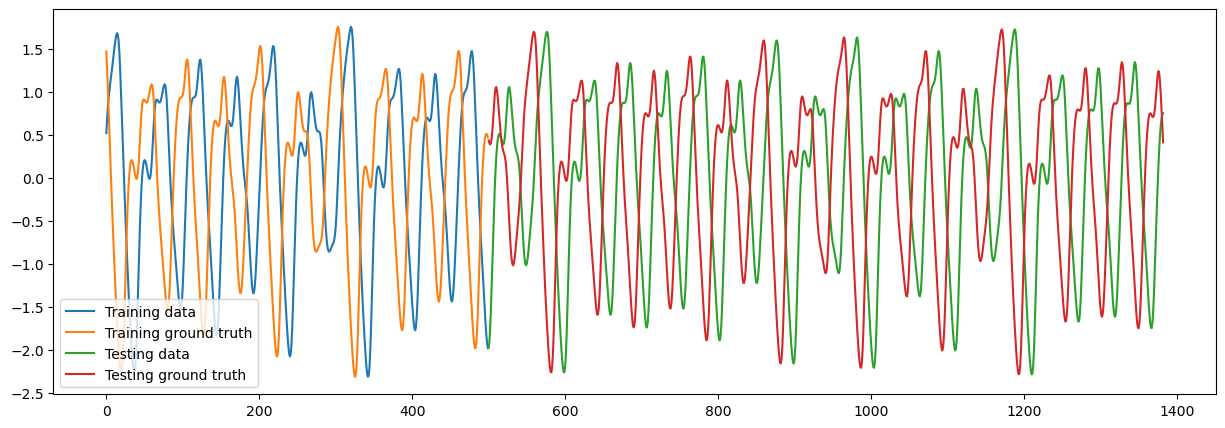

In [6]:
from reservoirpy.datasets import to_forecasting

X, Y = to_forecasting(X, forecast=17)
X_train1, Y_train1 = X[:1500], Y[:1500]
X_test1, Y_test1 = X[1500:], Y[1500:]

plot_train_test(X_train1, Y_train1, X_test1, Y_test1)

####
残りのパラメータは最終的にhyperopt(PythonにおけるBaysian optimization用のライブラリ)を用いて決定する。しかし、ここではhyperoptの中身に当たる部分を理解するために、先に定義しておく。

In [7]:
units = 500
leak_rate = 0.17113764962939737
spectral_radius = 1.182082887824895
input_scaling = 0.9697295578201843
connectivity = 0.10407566959031667      # - density of reservoir internal matrix
input_connectivity = 0.2  # and of reservoir input matrix
regularization = 5.602814683095597e-09
noise_rc = 3.297333463106559e-05
seed = 1234             # for reproducibility

In [8]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [9]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed, 
                      noise_rc=noise_rc, noise_type="normal")

readout   = Ridge(1, ridge=regularization)

esn = reservoir >> readout

In [10]:
y = esn(X[0])  # initialisation
reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [11]:
np.all(readout.Wout == 0.0)

True

In [12]:
esn = esn.fit(X_train1, Y_train1, warmup=100)

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-0: 1500it [00:00, 13014.04it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

Fitting node Ridge-0...


In [13]:
def plot_readout(readout):
    Wout = readout.Wout
    bias = readout.bias
    Wout = np.r_[bias, Wout]

    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(111)
    ax.grid(axis="y")
    ax.set_ylabel("Coefs. of $W_{out}$")
    ax.set_xlabel("reservoir neurons index")
    ax.bar(np.arange(Wout.size), Wout.ravel()[::-1])

    plt.show()

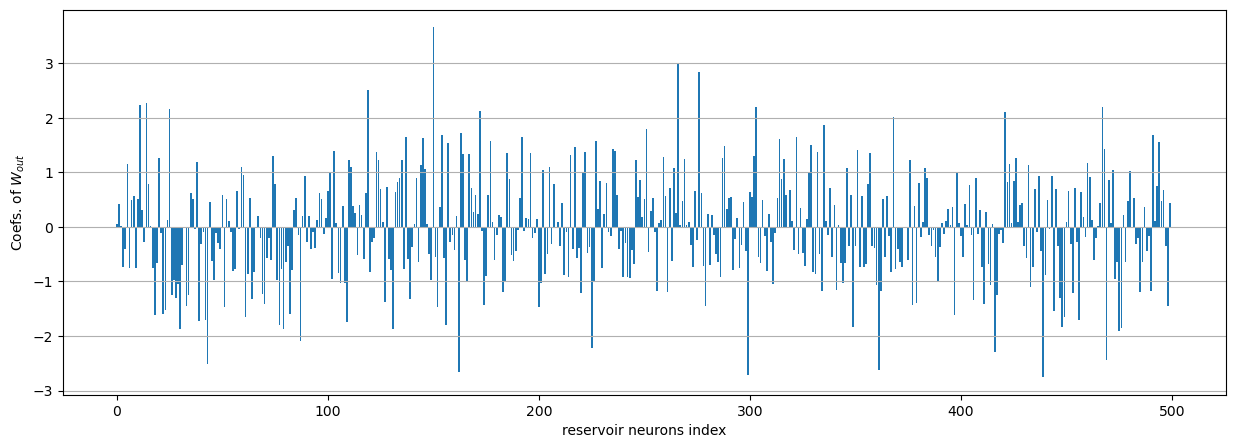

In [14]:
plot_readout(readout)

In [15]:
def plot_results(y_pred, y_test, sample=500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [16]:
Y_pred1 = esn.run(X_test1)

Running Model-0: 883it [00:00, 13469.19it/s]          


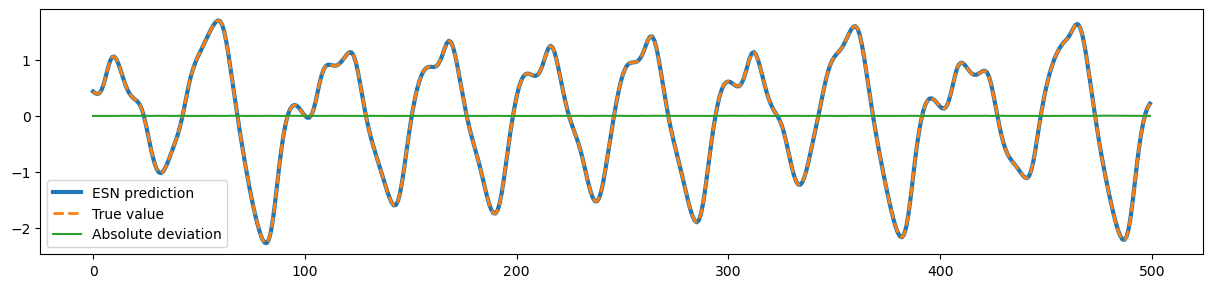

In [17]:
plot_results(Y_pred1, Y_test1)

In [18]:
rsquare(Y_test1, Y_pred1), nrmse(Y_test1, Y_pred1)

(0.9999959051904533, 0.0004999456535846816)

それでは、Baysian Optimizationを使ってみる。

In [19]:
def objective(dataset, config, *, cell_number, leak_rate, spectral_radius, input_connectivity, input_scaling, connectivity, regularization, noise_rc, seed):
    
    X, Y = to_forecasting(dataset, forecast=10)
    X_train1, Y_train1 = X[:1500], Y[:1500]
    X_test1, Y_test1 = X[1500:], Y[1500:]
    
    instances = config["instances_per_trial"]

    variable_seed = seed 
        
    losses = []; r2s = [];
    for n in range(instances):
        reservoir = Reservoir(cell_number, input_scaling=input_scaling, sr=spectral_radius,
                        lr=leak_rate, rc_connectivity=connectivity, 
                        noise_rc=noise_rc, noise_type="normal",
                        input_connectivity=input_connectivity, seed=seed)

        readout   = Ridge(1, ridge=regularization)

        esn = reservoir >> readout
            
        esn = esn.fit(X_train1, Y_train1, warmup=100)
        
        Y_pred1 = esn.run(X_test1)
        
        loss = nrmse(Y_test1, Y_pred1)
        r2 = rsquare(Y_test1, Y_pred1)
        
        losses.append(loss)
        r2s.append(r2)
        
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [20]:
hyperopt_config = {
    "exp": f"hyperopt-MG-onestep-prediction", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "cell_number": ["choice", 500],             # the number of neurons is fixed to 500
        "spectral_radius": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "leak_rate": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "input_connectivity": ["choice", 0.2], # the number of neurons is fixed to 0.2
        "regularization": ["loguniform", 1e-10, 1],  # the regularization parameter is log-uniformly distributed between 1e-10 and 1.
        "connectivity": ["uniform", 0, 1], # the connectivity of the random network in the hidden layer uniformly distributed between 0 and 1.
        "noise_rc": ["loguniform", 1e-5, 1], #noise amplitude is log-uniformly distributed between 1e-5 and 1
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [21]:
#パラメータ設定
#実行が終わらないので、いくつかのパラメータの桁数を減らした

from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

tau = 17
timesteps = 2400 
#warmup:10000 timesteps, training: 150000, 
#teseting data(Baysian optimization, short-term prediction) : 900


X = mackey_glass(timesteps, tau=tau)
#ここではz-score normalizationを使用。
X = (X - np.mean(X)) / np.std(X) 

In [22]:
from reservoirpy.hyper import research

best = research(objective, X, f"{hyperopt_config['exp']}.config.json", ".")

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1: 1322it [00:00, 13212.58it/s]         
Running Model-1: 1500it [00:00, 12960.96it/s]
Running Model-1: 100%|##########| 1/1 [00:00<00:00,  7.77it/s]


Fitting node Ridge-1...                                
  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1: 890it [00:00, 13718.51it/s]          
Running Model-2:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-2: 1304it [00:00, 13032.18it/s]         
Running Model-2: 1500it [00:00, 12737.55it/s]
Running Model-2: 100%|##########| 1/1 [00:00<00:00,  7.61it/s]


Fitting node Ridge-2...                                
  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-2:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-2: 890it [00:00, 13121.21it/s]          
Running Model-3:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-3: 1341it [00:00, 13401.55it/s]         
Running Model-3: 1500it [00:00, 13230.66it/s]
Running Model-3: 100%|##########| 1/1 [00:00<00:00,  7.95it/s]


Fitting node Ridge-3...                                
  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-3:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-3: 890it [00:00, 13400.43it/s]          


  0%|          | 1/200 [00:00<03:02,  1.09trial/s, best loss: 0.3043412768399459]

Running Model-4:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-4: 1425it [00:00, 14246.75it/s]         
Running Model-4: 1500it [00:00, 14022.39it/s]
Running Model-4: 100%|##########| 1/1 [00:00<00:00,  8.24it/s]


Fitting node Ridge-4...                                                          
  0%|          | 1/200 [00:01<03:02,  1.09trial/s, best loss: 0.3043412768399459]

Running Model-4:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-4: 890it [00:00, 14656.88it/s]          
Running Model-5:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-5: 1431it [00:00, 14309.47it/s]         
Running Model-5: 1500it [00:00, 14036.29it/s]
Running Model-5: 100%|##########| 1/1 [00:00<00:00,  8.32it/s]


Fitting node Ridge-5...                                                          
  0%|          | 1/200 [00:01<03:02,  1.09trial/s, best loss: 0.3043412768399459]

Running Model-5:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-5: 890it [00:00, 14752.22it/s]          
Running Model-6:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-6: 1437it [00:00, 14365.25it/s]         
Running Model-6: 1500it [00:00, 14078.69it/s]
Running Model-6: 100%|##########| 1/1 [00:00<00:00,  8.44it/s]


Fitting node Ridge-6...                                                          
  0%|          | 1/200 [00:01<03:02,  1.09trial/s, best loss: 0.3043412768399459]

Running Model-6:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-6: 890it [00:00, 14970.89it/s]          


  1%|          | 2/200 [00:01<02:57,  1.12trial/s, best loss: 0.3043412768399459]

Running Model-7:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-7: 352it [00:00, 3514.51it/s]           
Running Model-7: 708it [00:00, 3536.46it/s]
Running Model-7: 1064it [00:00, 3544.85it/s]
Running Model-7: 1420it [00:00, 3550.66it/s]
Running Model-7: 1500it [00:00, 3535.10it/s]
Running Model-7: 100%|##########| 1/1 [00:00<00:00,  2.29it/s]


Fitting node Ridge-7...                                                          
  1%|          | 2/200 [00:02<02:57,  1.12trial/s, best loss: 0.3043412768399459]

Running Model-7:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-7: 331it [00:00, 3309.77it/s]           
Running Model-7: 688it [00:00, 3460.40it/s]
Running Model-7: 890it [00:00, 3440.62it/s]
Running Model-8:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-8: 351it [00:00, 3507.26it/s]           
Running Model-8: 705it [00:00, 3522.08it/s]
Running Model-8: 1058it [00:00, 3512.23it/s]
Running Model-8: 1413it [00:00, 3525.06it/s]
Running Model-8: 1500it [00:00, 3511.03it/s]
Running Model-8: 100%|##########| 1/1 [00:00<00:00,  2.27it/s]


Fitting node Ridge-8...                                                          
  1%|          | 2/200 [00:03<02:57,  1.12trial/s, best loss: 0.3043412768399459]

Running Model-8:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-8: 354it [00:00, 3535.79it/s]           
Running Model-8: 716it [00:00, 3580.71it/s]
Running Model-8: 890it [00:00, 3565.15it/s]
Running Model-9:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-9: 355it [00:00, 3545.56it/s]           
Running Model-9: 711it [00:00, 3551.27it/s]
Running Model-9: 1069it [00:00, 3560.53it/s]
Running Model-9: 1426it [00:00, 3531.51it/s]
Running Model-9: 1500it [00:00, 3531.93it/s]
Running Model-9: 100%|##########| 1/1 [00:00<00:00,  2.27it/s]


Fitting node Ridge-9...                                                          
  1%|          | 2/200 [00:04<02:57,  1.12trial/s, best loss: 0.3043412768399459]

Running Model-9:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-9: 352it [00:00, 3510.53it/s]           
Running Model-9: 704it [00:00, 3329.76it/s]
Running Model-9: 890it [00:00, 3375.25it/s]


  2%|▏         | 3/200 [00:04<06:16,  1.91s/trial, best loss: 0.3043412768399459]

Running Model-10:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-10: 573it [00:00, 5727.59it/s]           
Running Model-10: 1146it [00:00, 5715.63it/s]
Running Model-10: 1500it [00:00, 5693.57it/s]
Running Model-10: 100%|##########| 1/1 [00:00<00:00,  3.62it/s]


Fitting node Ridge-10...                                                         
  2%|▏         | 3/200 [00:05<06:16,  1.91s/trial, best loss: 0.3043412768399459]

Running Model-10:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-10: 574it [00:00, 5735.93it/s]           
Running Model-10: 890it [00:00, 5732.28it/s]
Running Model-11:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-11: 566it [00:00, 5654.79it/s]           
Running Model-11: 1133it [00:00, 5660.08it/s]
Running Model-11: 1500it [00:00, 5660.65it/s]
Running Model-11: 100%|##########| 1/1 [00:00<00:00,  3.62it/s]


Fitting node Ridge-11...                                                         
  2%|▏         | 3/200 [00:06<06:16,  1.91s/trial, best loss: 0.3043412768399459]

Running Model-11:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-11: 580it [00:00, 5792.82it/s]           
Running Model-11: 890it [00:00, 5781.14it/s]
Running Model-12:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-12: 547it [00:00, 5461.98it/s]           
Running Model-12: 1120it [00:00, 5618.36it/s]
Running Model-12: 1500it [00:00, 5614.13it/s]
Running Model-12: 100%|##########| 1/1 [00:00<00:00,  3.59it/s]


Fitting node Ridge-12...                                                         
  2%|▏         | 3/200 [00:06<06:16,  1.91s/trial, best loss: 0.3043412768399459]

Running Model-12:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-12: 575it [00:00, 5745.36it/s]           
Running Model-12: 890it [00:00, 5707.66it/s]


  2%|▏         | 4/200 [00:07<06:34,  2.01s/trial, best loss: 0.2759356402394813]

Running Model-13:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-13: 667it [00:00, 6663.27it/s]           
Running Model-13: 1356it [00:00, 6796.27it/s]
Running Model-13: 1500it [00:00, 6762.67it/s]
Running Model-13: 100%|##########| 1/1 [00:00<00:00,  4.26it/s]


Fitting node Ridge-13...                                                         
  2%|▏         | 4/200 [00:07<06:34,  2.01s/trial, best loss: 0.2759356402394813]

Running Model-13:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-13: 711it [00:00, 7108.79it/s]           
Running Model-13: 890it [00:00, 7036.85it/s]
Running Model-14:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-14: 700it [00:00, 6999.42it/s]           
Running Model-14: 1400it [00:00, 6982.55it/s]
Running Model-14: 1500it [00:00, 6950.36it/s]
Running Model-14: 100%|##########| 1/1 [00:00<00:00,  4.40it/s]


Fitting node Ridge-14...                                                         
  2%|▏         | 4/200 [00:07<06:34,  2.01s/trial, best loss: 0.2759356402394813]

Running Model-14:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-14: 697it [00:00, 6962.98it/s]           
Running Model-14: 890it [00:00, 6863.95it/s]
Running Model-15:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-15: 701it [00:00, 7008.40it/s]           
Running Model-15: 1402it [00:00, 6805.71it/s]
Running Model-15: 1500it [00:00, 6764.32it/s]
Running Model-15: 100%|##########| 1/1 [00:00<00:00,  4.20it/s]


Fitting node Ridge-15...                                                         
  2%|▏         | 4/200 [00:08<06:34,  2.01s/trial, best loss: 0.2759356402394813]

Running Model-15:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-15: 698it [00:00, 6973.94it/s]           
Running Model-15: 890it [00:00, 6929.68it/s]


  2%|▎         | 5/200 [00:08<06:05,  1.87s/trial, best loss: 0.2759356402394813]

Running Model-16:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-16: 512it [00:00, 5116.97it/s]           
Running Model-16: 1024it [00:00, 5105.21it/s]
Running Model-16: 1500it [00:00, 5083.73it/s]
Running Model-16: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-16...                                                         
  2%|▎         | 5/200 [00:09<06:05,  1.87s/trial, best loss: 0.2759356402394813]

Running Model-16:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-16: 512it [00:00, 5110.85it/s]           
Running Model-16: 890it [00:00, 5099.82it/s]
Running Model-17:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-17: 520it [00:00, 5189.06it/s]           
Running Model-17: 1039it [00:00, 5188.39it/s]
Running Model-17: 1500it [00:00, 5173.29it/s]
Running Model-17: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-17...                                                         
  2%|▎         | 5/200 [00:09<06:05,  1.87s/trial, best loss: 0.2759356402394813]

Running Model-17:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-17: 527it [00:00, 5260.16it/s]           
Running Model-17: 890it [00:00, 5264.25it/s]
Running Model-18:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-18: 522it [00:00, 5218.14it/s]           
Running Model-18: 1046it [00:00, 5230.57it/s]
Running Model-18: 1500it [00:00, 5218.81it/s]
Running Model-18: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-18...                                                         
  2%|▎         | 5/200 [00:10<06:05,  1.87s/trial, best loss: 0.2759356402394813]

Running Model-18:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-18: 502it [00:00, 5018.90it/s]           
Running Model-18: 890it [00:00, 5044.38it/s]


  3%|▎         | 6/200 [00:10<06:12,  1.92s/trial, best loss: 0.2759356402394813]

Running Model-19:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-19: 304it [00:00, 3033.72it/s]           
Running Model-19: 610it [00:00, 3042.03it/s]
Running Model-19: 920it [00:00, 3067.00it/s]
Running Model-19: 1230it [00:00, 3076.83it/s]
Running Model-19: 1500it [00:00, 3068.05it/s]
Running Model-19: 100%|##########| 1/1 [00:00<00:00,  1.99it/s]


Fitting node Ridge-19...                                                         
  3%|▎         | 6/200 [00:11<06:12,  1.92s/trial, best loss: 0.2759356402394813]

Running Model-19:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-19: 314it [00:00, 3132.45it/s]           
Running Model-19: 628it [00:00, 3085.97it/s]
Running Model-19: 890it [00:00, 3086.04it/s]
Running Model-20:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-20: 311it [00:00, 3105.66it/s]           
Running Model-20: 622it [00:00, 3098.14it/s]
Running Model-20: 934it [00:00, 3105.12it/s]
Running Model-20: 1246it [00:00, 3109.76it/s]
Running Model-20: 1500it [00:00, 3098.98it/s]
Running Model-20: 100%|##########| 1/1 [00:00<00:00,  2.02it/s]


Fitting node Ridge-20...                                                         
  3%|▎         | 6/200 [00:12<06:12,  1.92s/trial, best loss: 0.2759356402394813]

Running Model-20:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-20: 313it [00:00, 3124.10it/s]           
Running Model-20: 629it [00:00, 3141.64it/s]
Running Model-20: 890it [00:00, 3130.96it/s]
Running Model-21:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-21: 314it [00:00, 3138.53it/s]           
Running Model-21: 635it [00:00, 3179.12it/s]
Running Model-21: 955it [00:00, 3184.99it/s]
Running Model-21: 1274it [00:00, 3167.69it/s]
Running Model-21: 1500it [00:00, 3158.95it/s]
Running Model-21: 100%|##########| 1/1 [00:00<00:00,  2.05it/s]


Fitting node Ridge-21...                                                         
  3%|▎         | 6/200 [00:13<06:12,  1.92s/trial, best loss: 0.2759356402394813]

Running Model-21:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-21: 317it [00:00, 3160.83it/s]           
Running Model-21: 634it [00:00, 3112.26it/s]
Running Model-21: 890it [00:00, 3084.12it/s]


  4%|▎         | 7/200 [00:14<07:53,  2.45s/trial, best loss: 0.007779825106957381]

Running Model-22:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-22: 395it [00:00, 3948.45it/s]           
Running Model-22: 790it [00:00, 3948.32it/s]
Running Model-22: 1186it [00:00, 3951.41it/s]
Running Model-22: 1500it [00:00, 3946.18it/s]
Running Model-22: 100%|##########| 1/1 [00:00<00:00,  2.54it/s]


Fitting node Ridge-22...                                                           
  4%|▎         | 7/200 [00:14<07:53,  2.45s/trial, best loss: 0.007779825106957381]

Running Model-22:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-22: 384it [00:00, 3838.07it/s]           
Running Model-22: 772it [00:00, 3858.28it/s]
Running Model-22: 890it [00:00, 3839.32it/s]
Running Model-23:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-23: 392it [00:00, 3914.99it/s]           
Running Model-23: 787it [00:00, 3934.05it/s]
Running Model-23: 1182it [00:00, 3940.37it/s]
Running Model-23: 1500it [00:00, 3932.31it/s]
Running Model-23: 100%|##########| 1/1 [00:00<00:00,  2.53it/s]


Fitting node Ridge-23...                                                           
  4%|▎         | 7/200 [00:15<07:53,  2.45s/trial, best loss: 0.007779825106957381]

Running Model-23:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-23: 398it [00:00, 3974.74it/s]           
Running Model-23: 535it [00:00, 3928.68it/s]


  4%|▎         | 7/200 [00:15<07:16,  2.26s/trial, best loss: 0.007779825106957381]


KeyboardInterrupt: 

$warmup = 100\Delta t$, 

$training = 1500\Delta t$, 

$testing = 900\Delta t$

合計$2400\Delta t$timestepで7分かかった。

最適化のパラメータ＋timetepの数で計算量が増える？

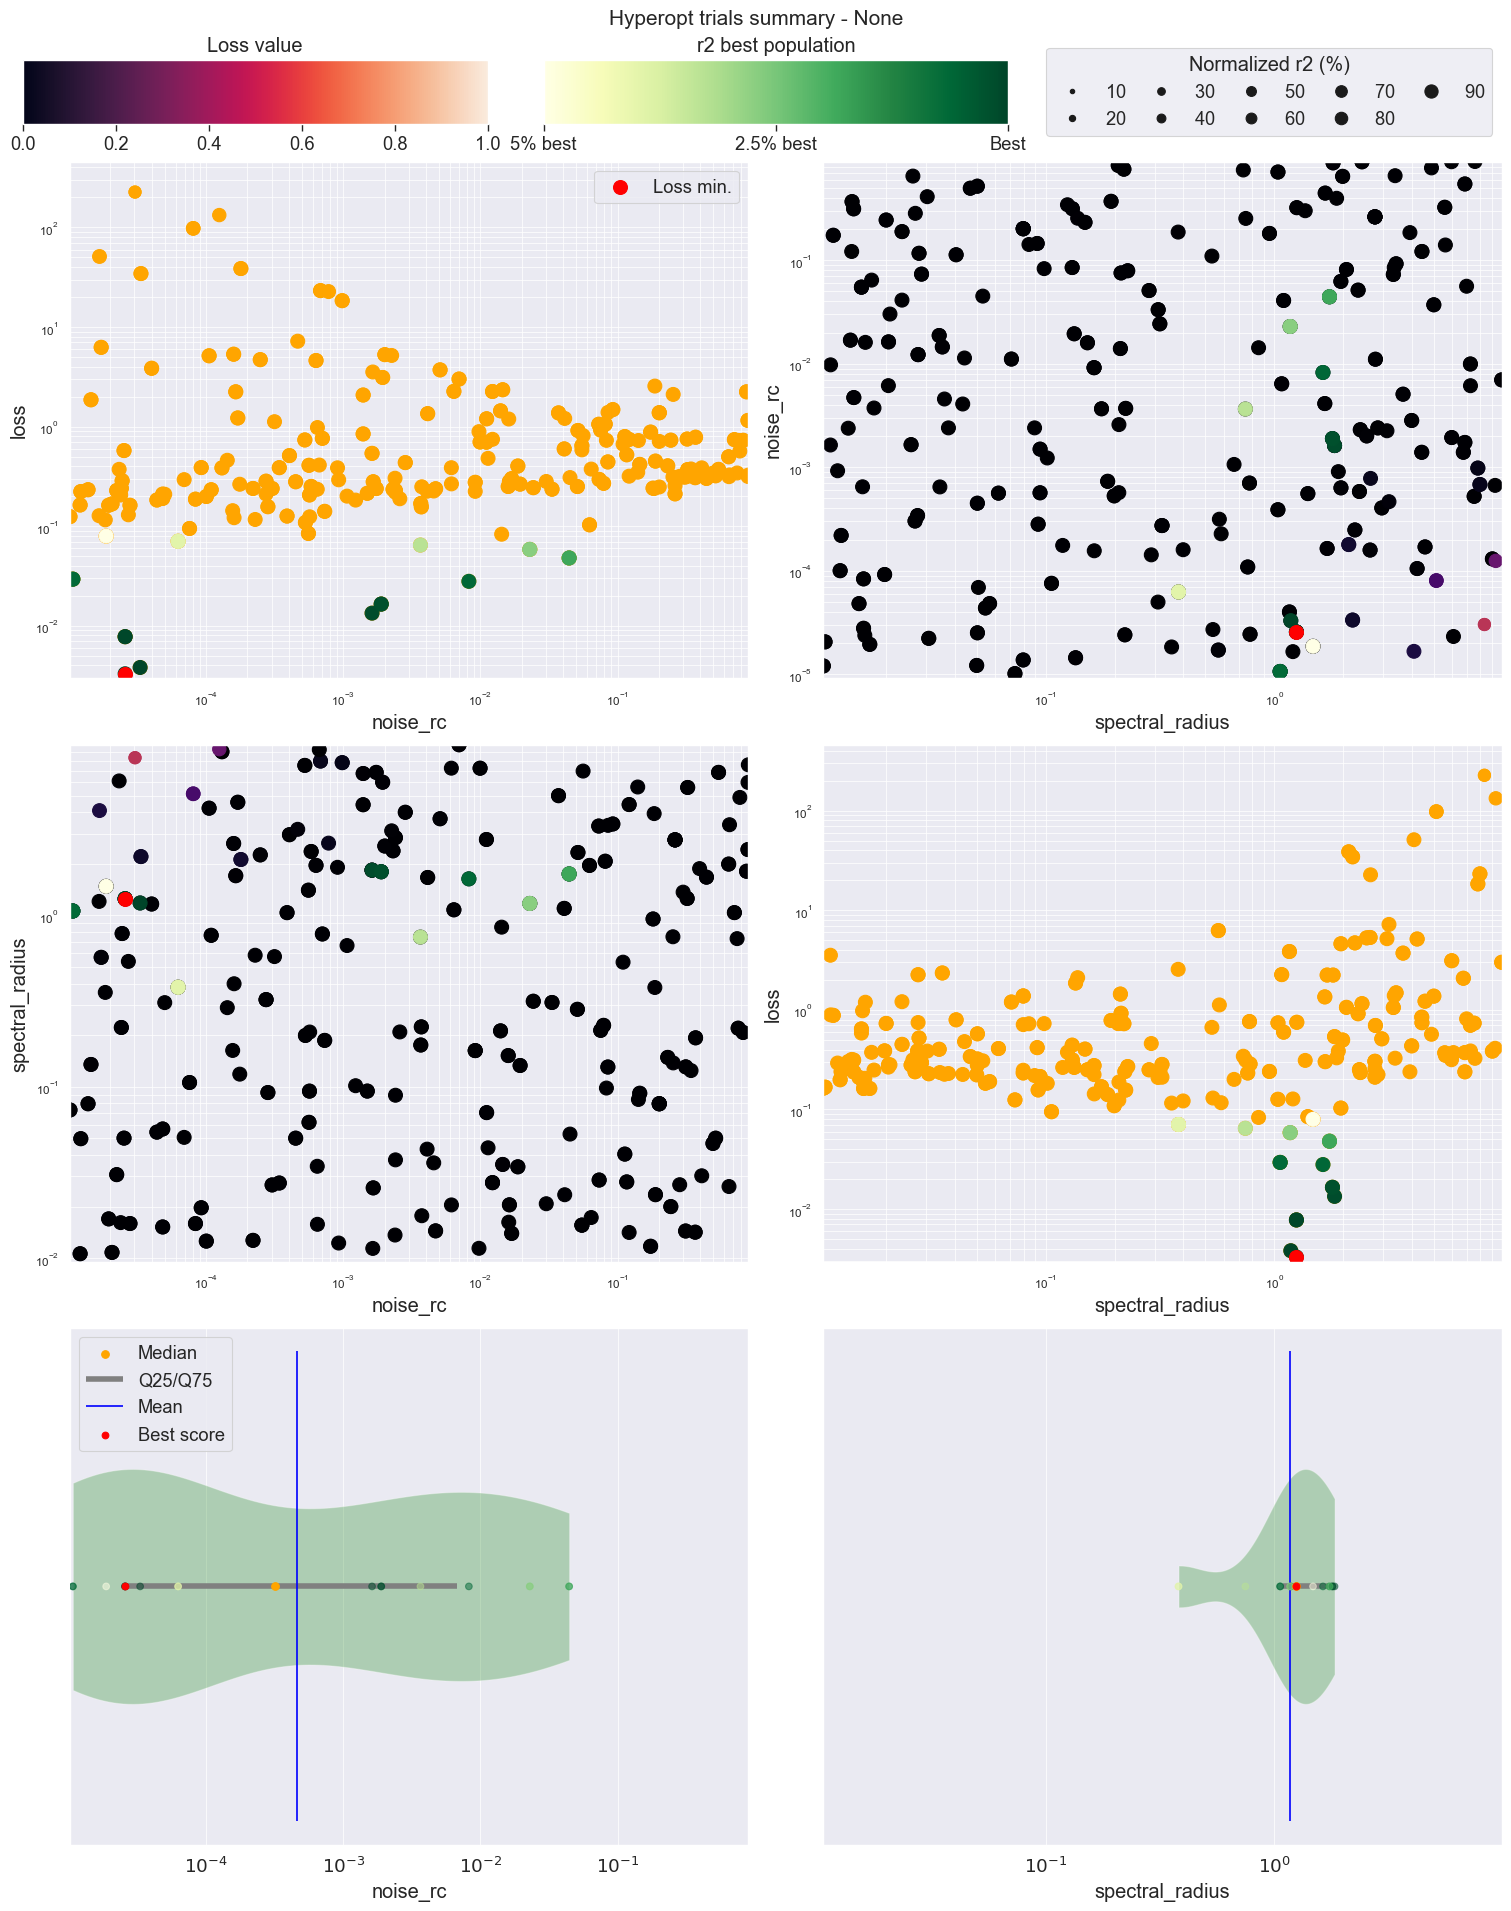

In [ ]:
from reservoirpy.hyper import plot_hyperopt_report

fig = plot_hyperopt_report(hyperopt_config["exp"], ("noise_rc", "spectral_radius"), metric="r2")

In [ ]:
#最適化されたパラメータを出力する。
best

({'cell_number': 0,
  'connectivity': 0.10407566959031667,
  'input_connectivity': 0,
  'input_scaling': 0.9697295578201843,
  'leak_rate': 0.17113764962939737,
  'noise_rc': 3.297333463106559e-05,
  'regularization': 5.602814683095597e-09,
  'seed': 0,
  'spectral_radius': 1.182082887824895},
 <hyperopt.base.Trials at 0x177466070>)

・各パラメータの探索範囲は？

$10 ^{−3.42} \approx 0.000376493580679246$

$ 3.297333463106559e-05 = 0.00003297333463106559$

In [ ]:
def plot_mackey_glass2(X, Y_pred, sample, tau):

    fig = plt.figure(figsize=(13, 5))
    N = sample

    ax = plt.subplot((121))
    t = np.linspace(0, N, N)
    for i in range(N-1):
        ax.plot(t[i:i+2], X[i:i+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Timeseries - {N} timesteps")
    plt.xlabel("$t$")
    plt.ylabel("$P(t)$")

    ax2 = plt.subplot((122))
    ax2.margins(0.05)
    for i in range(N-1):
        ax2.plot(X[i:i+2], Y_pred[i:i+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
    plt.xlabel("$P(t-\\tau)$")
    plt.ylabel("$P(t)$")

    plt.tight_layout()
    plt.show()

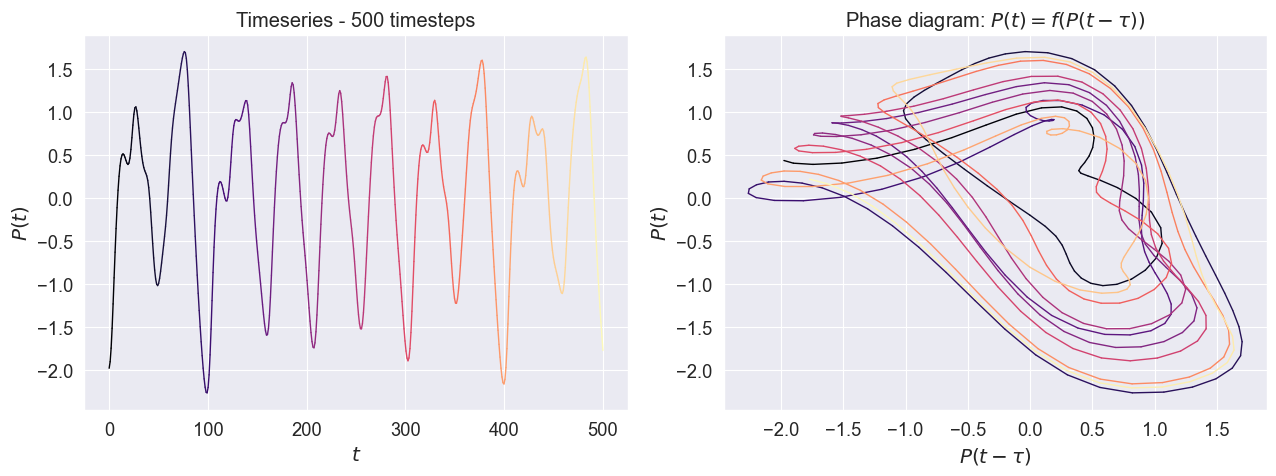

In [ ]:
plot_mackey_glass2(X_test1, Y_pred1, 500, tau)

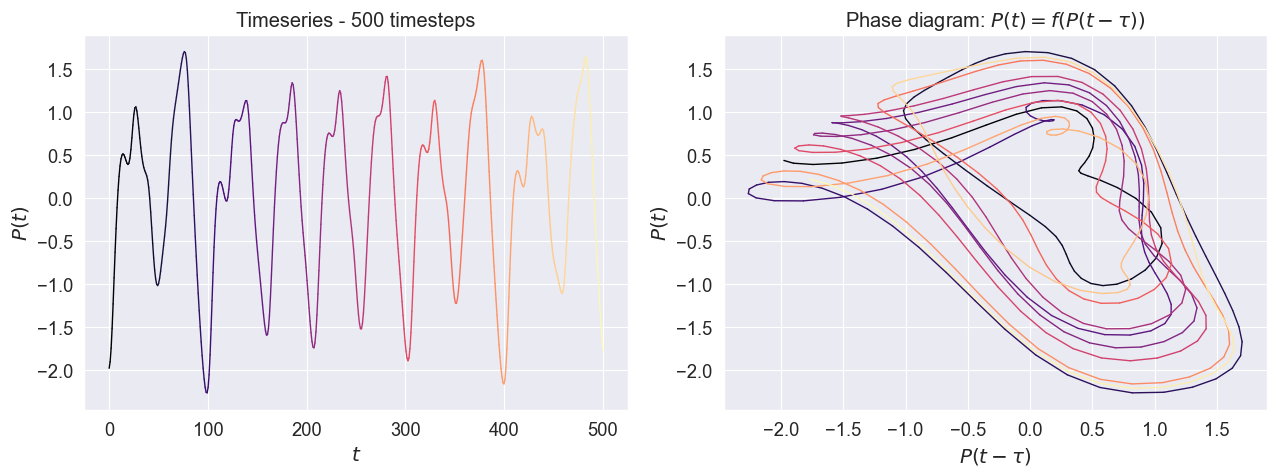

In [ ]:
plot_mackey_glass2(X_test1, Y_test1, 500, tau)

In [ ]:
def plot_mackey_glass(X, sample, tau):

    fig = plt.figure(figsize=(13, 5))
    N = sample

    ax = plt.subplot((121))
    t = np.linspace(0, N, N)
    for i in range(N-1):
        ax.plot(t[i:i+2], X[i:i+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Timeseries - {N} timesteps")
    plt.xlabel("$t$")
    plt.ylabel("$P(t)$")

    ax2 = plt.subplot((122))
    ax2.margins(0.05)
    for i in range(N-1):
        ax2.plot(X[i:i+2], X[i+tau:i+tau+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
    plt.xlabel("$P(t-\\tau)$")
    plt.ylabel("$P(t)$")

    plt.tight_layout()
    plt.show()

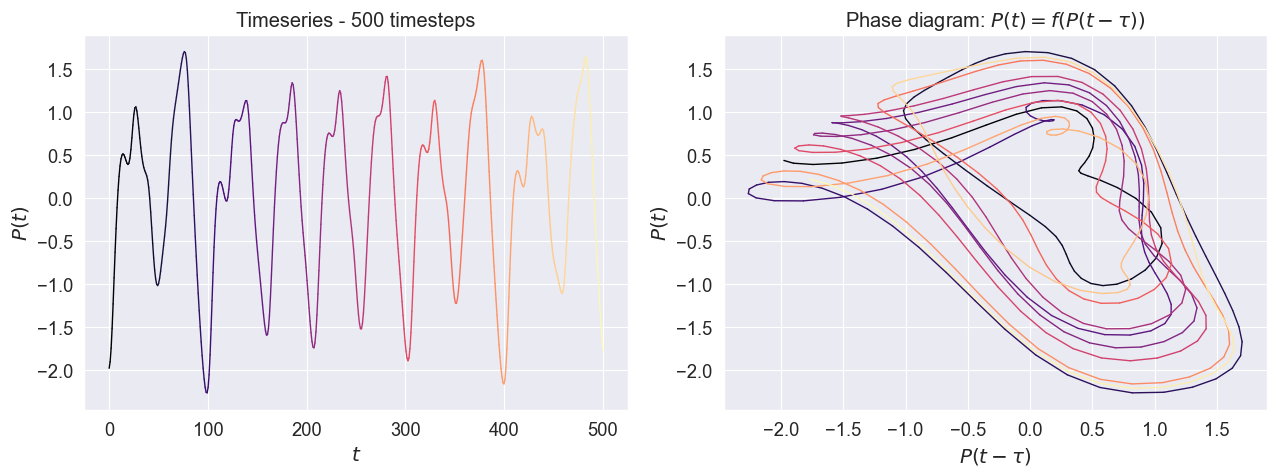

In [ ]:
plot_mackey_glass(X_test1, 500, tau)

今後の流れ
・RMSE、Prediction horizon, stabilityの三つの指数を導入して、$\sigma$との関連を調べる。